### Imports

In [1]:
from typing import Generator

from lavis.models import load_model_and_preprocess
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import cv2

/home/tommysugg/VideoCaptioningWithBLIP2/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions

In [2]:
def get_video_frames_generator(source_path: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(source_path)
    if not video.isOpened():
        raise Exception(f"Could not open video at {source_path}")
    success, frame = video.read()
    while success:
        yield Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        success, frame = video.read()
    video.release()
    
def normalize(vec: np.ndarray):
    return vec / np.linalg.norm(vec, axis=1, keepdims=True)

In [3]:
SOURCE_VIDEO_PATH = 'input/dog.mp4'
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [4]:
### This is the model for captioning
model, vis_processors, txt_processors = load_model_and_preprocess(
    name="blip_caption", model_type="large_coco", is_eval=True, device=device
)
vis_processors.keys()

### This is the model for extracting embeddings
model_extractor, vis_processors_extractor, txt_processors_extractor = load_model_and_preprocess(
    name="blip_feature_extractor", model_type="base", is_eval=True, device=device
)

In [26]:
### Get caption for every second (24 frames)
captions = []
frames = []
indices = []
 
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

for index, frame in enumerate(generator):
    try:
        if index % 24 == 0:
            image = vis_processors["eval"](frame).unsqueeze(0).to(device)
            caption = model.generate({"image": image})[0]

            captions.append(caption)
            frames.append(frame)
            indices.append(index)
    except:
        pass

### Get embeddings for every caption
sample = {"text_input": captions}
features_text = model_extractor.extract_features(sample, mode="text")

In [49]:
### Observe captions
captions[:10]

['a dog laying on the sidewalk in a city',
 'a dog laying on the sidewalk in a city',
 'a dog laying on the sidewalk in a city',
 'a dog laying on the sidewalk in a city',
 'a dog laying on the sidewalk in a city',
 'a dog laying on the sidewalk next to a woman',
 'a dog laying on the sidewalk in a city',
 'a dog laying on the sidewalk in a city',
 'a dog laying on the sidewalk in a city',
 'a dog laying on the sidewalk in a city']

In [42]:
### Find duplicate neighboring captions using embeddings
indices_flag = []
for x in range(len(features_text.text_embeds_proj)):
    if x == 0: 
        indices_flag.append(True)
        continue
    if x == len(features_text.text_embeds_proj)-1:
        indices_flag.append(True)
        break

    similarity = np.dot(normalize(features_text.text_embeds_proj[x].cpu().detach().numpy().flatten().reshape(1,-1)), normalize(features_text.text_embeds_proj[x-1].cpu().detach().numpy().flatten().reshape(1,-1)).T)
    
    if similarity >= 0.9:
        indices_flag.append(False)
    else:
        indices_flag.append(True)

In [43]:
###  Remove duplicate neighboring embeddings
captions_array = np.asarray(captions)
indices_flag_array = np.asarray(indices_flag)
indices_array = np.asarray(indices)
frames_array = np.asarray([np.asarray(i) for i in frames])

captions_array = captions_array[indices_flag_array]
frames_array = frames_array[indices_flag_array]
indices_array = indices_array[indices_flag_array]

In [51]:
### Observe duplicates 
np.asarray(captions)[~indices_flag_array]

array(['a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying on the sidewalk in a city',
       'a dog laying

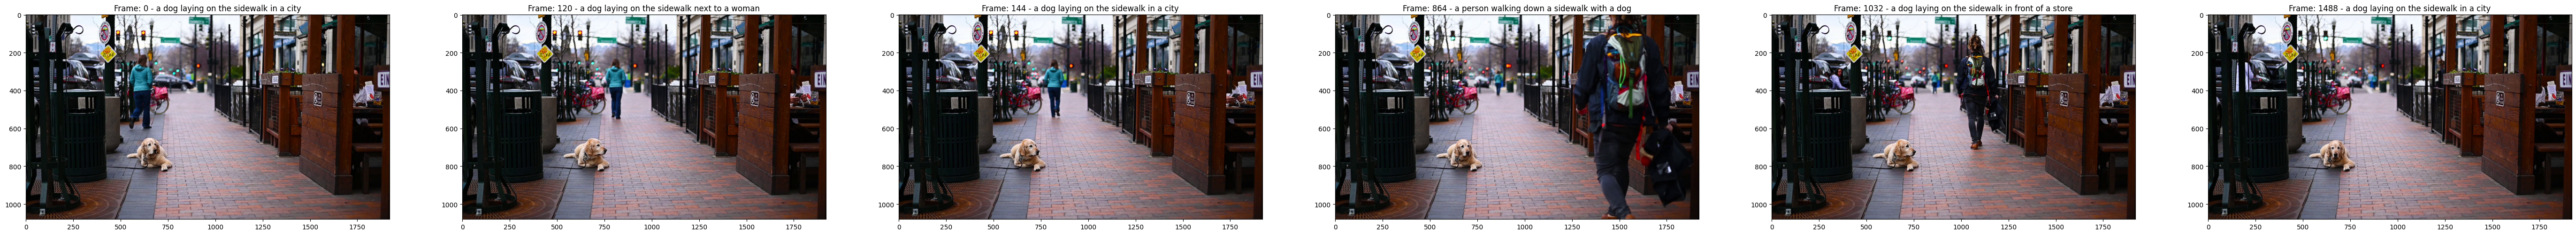

In [50]:
### Visualize
fig, axs = plt.subplots(1, len(captions_array), figsize=(70,15))

for i in range(len(captions_array)):
    axs[i].imshow(frames_array[i])
    axs[i].set_title(f"Frame: {indices_array[i]} - {captions_array[i]}")
    
fig.savefig('output/key_frames_in_video.png')